## Deep Learning 

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import Input
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from IPython.display import Image
from IPython.core.display import HTML 

### Simple Example

#### Load Data

In [4]:
lbl = ['Time', 'flowrate','water temp','pH','BOD5','COD','SS','TN','TP']
path_data = './2011.csv'
data = pd.read_csv(path_data, sep=';') 

@interact
def show_per_year(columns='flowrate', x=(10067,16332,1)):
    return data.loc[data[columns] > x, lbl]

interactive(children=(Text(value='flowrate', description='columns'), IntSlider(value=13199, description='x', m…

#### Augment Data

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_data(matrix, limit=[0,-1],title='data',scaled=False):
    limit = np.asarray(limit, dtype=np.int)
    fix, ax = plt.subplots(2,4, figsize=(10,4))
    ax[0,0].plot(matrix[limit[0]:limit[1],0])
    ax[0,0].set_title("Flowrate")
    ax[0,1].plot(matrix[limit[0]:limit[1],1])
    ax[0,1].set_title("Water Temp")
    ax[0,2].plot(matrix[limit[0]:limit[1],2])
    ax[0,2].set_title("pH")
    ax[0,3].plot(matrix[limit[0]:limit[1],3])
    ax[0,3].set_title("BOD5")
    ax[1,0].plot(matrix[limit[0]:limit[1],4])
    ax[1,0].set_title("COD")
    ax[1,1].plot(matrix[limit[0]:limit[1],5])
    ax[1,1].set_title("SS")
    ax[1,2].plot(matrix[limit[0]:limit[1],6])
    ax[1,2].set_title("TN")
    ax[1,3].plot(matrix[limit[0]:limit[1],7])
    ax[1,3].set_title("TP")
    
    if scaled:
        ax[0,0].set_ylim([0,1])
        ax[0,1].set_ylim([0,1])
        ax[0,2].set_ylim([0,1])
        ax[0,3].set_ylim([0,1])
        ax[1,0].set_ylim([0,1])
        ax[1,1].set_ylim([0,1])
        ax[1,2].set_ylim([0,1])
        ax[1,3].set_ylim([0,1])
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [6]:
Image(url= "http://cs231n.github.io/assets/nn2/prepro2.jpeg")

Initial data shape:  (365, 8)
Data size:  (360, 8)
Windowed data:  (12, 30, 8)
prev shape:  (171, 30, 8)
next shape:  (171, 30, 8, 1)
Plotting data direct from csv file


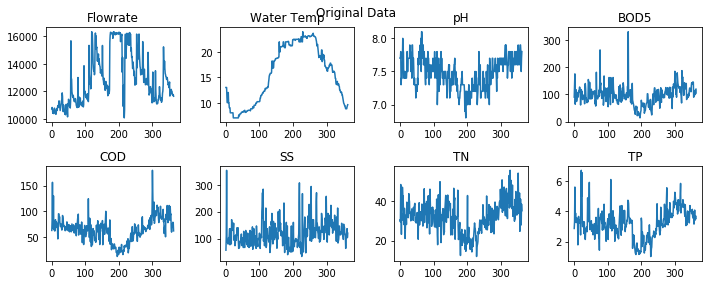

Plotting data after scaling


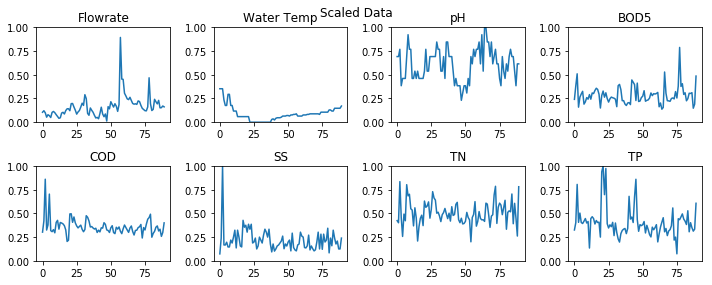

In [7]:
df = data.iloc[:,1:9].values
df = np.asarray(df, dtype=np.float32)
print('Initial data shape: ',df.shape)

# Prepare the dataset
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Extra functions to process the data
scaler = MinMaxScaler()
rbs_scaler = RobustScaler()
points_rbs = scaler.fit_transform(rbs_scaler.fit_transform(df))

# Create samples
window = 30
extra  = len(points_rbs) % window 
data = points_rbs[:-extra]
print('Data size: ',data.shape)
data.shape = (len(data) // window , window, 8)
print('Windowed data: ',data.shape)

# Augmenting the data
data_5  = points_rbs[5 :len(points_rbs)-((len(points_rbs)-5) % window)]
data_10 = points_rbs[10:len(points_rbs)-((len(points_rbs)-10) % window)]
data_15 = points_rbs[15:len(points_rbs)-((len(points_rbs)-15) % window)]
data_20 = points_rbs[20:len(points_rbs)-((len(points_rbs)-20) % window)]

data_5.shape  = (len(data_5)  // window , window, 8)
data_10.shape = (len(data_10) // window , window, 8)
data_15.shape = (len(data_15) // window , window, 8)
data_20.shape = (len(data_20) // window , window, 8)

data = np.concatenate([data, data_5, data_10, data_15, data_20])
noise_1 = 0.05*np.random.randn(data.shape[0],data.shape[1],data.shape[2])
noise_2 = 0.05*np.random.randn(data.shape[0],data.shape[1],data.shape[2])
data_x = np.concatenate([data, data+noise_1, data+noise_2])
data_y = np.concatenate([data, data, data])
print('prev shape: ',data_x.shape)
data_x = data_x[:,:,:,np.newaxis]
data_y = data_y[:,:,:,np.newaxis]
print('next shape: ',data_x.shape)

print('Plotting data direct from csv file')
plot_data(df,title='Original Data')
print('Plotting data after scaling')
plot_data(points_rbs, limit=[0,30*3], title='Scaled Data', scaled=True)

---
### Regularization

#### Early Stopping

In [8]:
Image(url= "https://lh3.googleusercontent.com/2Re85KrrB652LiKA9hz89r8VcrZ-qUrjzCEz4026VHvGDY_5WOk_88PXKg1ddPPKQjv8GLDYQPWU9iw0T-Z8Ur_GfbgIC_V5LnYMPxa30CIHIit8T5pUKo6t-akkU8kKlXAkTkLP")

``` python
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(10, input_dim=784, kernel_initializer='uniform'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
early_stop   = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto)

model.fit(x_train, y_train, 
          batch_size=128, 
          epochs=20, 
          verbose=0, 
          validation_data=(X_test, Y_test), 
          callbacks=[checkpointer, early_stop])

```

#### Dropout

In [9]:
Image(url= "https://miro.medium.com/max/1200/1*iWQzxhVlvadk6VAJjsgXgg.png")

 ``` python 
 
from tensorflow.keras.layers import Dropout

rate = 0.5

model = Sequential()
model.add(Dropout(rate))
model.add(Dense(10, input_dim=784, kernel_initializer='uniform'))
model.add(Activation('softmax'))
model.add(Dropout(rate))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.fit(x_train, y_train, 
          batch_size=128, 
          epochs=20, 
          verbose=0, 
          validation_data=(X_test, Y_test))
```

#### Weight Penalty
 
 ``` python 
 
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

def l1_reg(weight_matrix):
    return 0.01 * K.sum(K.abs(weight_matrix))

model = Sequential()
model.add(Dense(10, input_dim=784, 
                kernel_initializer='uniform',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(10, input_dim=64,
                kernel_initializer='uniform',
                kernel_regularizer=l1_reg))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
```

#### Batch Normalization

 ``` python 
 
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Dense(10, input_dim=784, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, input_dim=64,
                kernel_initializer='uniform',
                kernel_regularizer=l1_reg))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
```

---
### Autoencoder
At its most basic, an autoencoder is a neural netowrk trained to copy its input to its output. Internally consists of two parts: an encoder function $h=f(x)$ and a decoder function $r=g(h)$. Instead of simply learning to copy, autoencoders are desgined to be unable to copy perfectly. Beacuse the model is forced to prioritize which aspects of the input should be copied, it often learns useful properties of the data.

In [10]:
Image(url= "https://miro.medium.com/max/700/1*oaYo7uAOoKcdrun5uqADDw.png")

#### Denoising

In [11]:
Image(url= "https://static.packt-cdn.com/products/9781788399906/graphics/22856e76-19cc-428c-800b-b6292c16ab1b.png")

In [12]:
def AutoEncoder(input_shape, layer_filters, latent_dim):
    # First, build the Encoder Model
    kernel_size = 3
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for filters in layer_filters:
        x = L.Conv2D( filters=filters,
                      kernel_size=kernel_size,
                      activation='relu',
                      padding='same')(x)

    shape = K.int_shape(x)
    x = L.Flatten()(x)
    latent = L.Dense(latent_dim, name='latent_vector')(x)

    x = L.Dense(shape[1]*shape[2]*shape[3])(latent)
    x = L.Reshape((shape[1], shape[2], shape[3]))(x)
    for filters in layer_filters[::-1]:
        x = L.Conv2DTranspose( filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              strides=1,
                              padding='same')(x)
    x = L.Conv2D(filters=1,
               kernel_size=kernel_size,
               padding='same')(x)
    outputs = L.Activation('sigmoid', name='decoder_output')(x)
    decoder = Model(inputs, outputs, name='auto_encoder')
    return decoder


# Autoencoder(input_shape(m,n), layer_filters, latent dim)
autoencoder = AutoEncoder(data_x.shape[1:],[128,64,32], 256)
autoencoder.summary()
# Compile ,fit and evaluate model to the data
autoencoder.compile(loss='mse', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 30, 8, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 8, 128)        1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 8, 64)         73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 8, 32)         18464     
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1966336   
_________________________________________________________________
dens

Instructions for updating:
Use tf.cast instead.
171/171 [==============================] - 0s 1ms/sample - loss: 6.2834e-05
(171, 30, 8, 1)


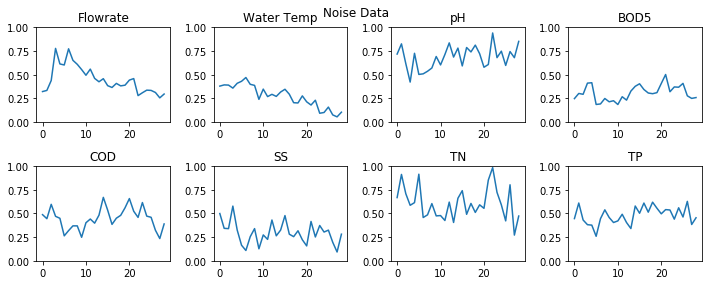

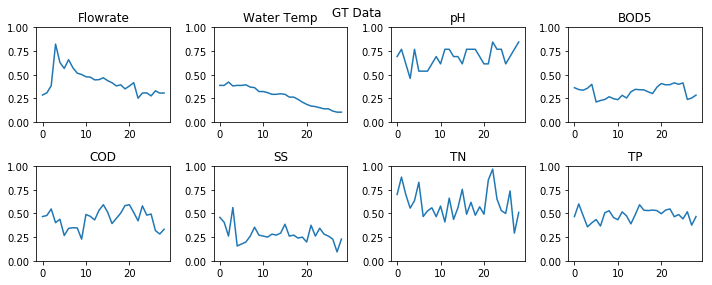

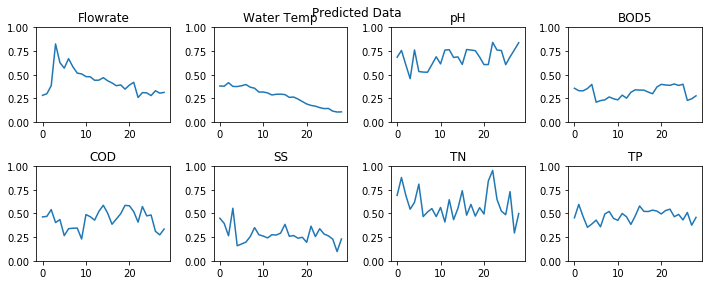

In [13]:
autoencoder.fit(x = data_x,
                y = data_y, 
                epochs=100, 
                batch_size=16, 
                shuffle=True,
                verbose=0)
autoencoder.evaluate(data_x,data_y)
pred = autoencoder.predict(data_x)
print(pred.shape)
plot_data(data_x[125,:,:,0], title='Noise Data', scaled=True)
plot_data(data_y[125,:,:,0], title='GT Data', scaled=True)
plot_data(pred[125,:,:,0], title='Predicted Data', scaled=True)

#### U-Net

In [14]:
Image(url= "http://static1.squarespace.com/static/5c081c159772ae210cc800e8/5c081e62e0c9382a1a8ca7de/5c081e70e0c9382a1a8ca962/1559623838310/TGS_Unet.jpg?format=1500w")

In [15]:
def Autoencoder_Unet(input_shape, latent_dim):
    filters = [32,64,128,128,64,32]
    kernel_size = 3

    xi = Input(shape=input_shape, name='encoder_input')
    x1 = L.Conv2D(filters=filters[0],
                  kernel_size=(kernel_size,1),
                  activation='relu',
                  padding='valid')(xi)
    x1 = L.MaxPooling2D()(x1)
    x2 = L.Conv2D(filters=filters[1],
               kernel_size=kernel_size,
               activation='relu',
               padding='same')(x1)
    x3 = L.Conv2D(filters=filters[2],
               kernel_size=kernel_size,
               activation='relu',
               padding='same')(x2)
    shape = K.int_shape(x3)
    xf = L.Flatten()(x3)
    xf = L.Dense(latent_dim, name='latent_vector')(xf)
    xf = L.Dense(shape[1] * shape[2] * shape[3])(xf)
    xf = L.Reshape((shape[1], shape[2], shape[3]))(xf)

    x4 = L.Conv2DTranspose(filters=filters[3],
                        kernel_size=kernel_size,
                        activation='relu',
                        padding='same')(xf)
    x4 = L.Add()([x3,x4])
    x5 = L.Conv2DTranspose(filters=filters[4],
                        kernel_size=kernel_size,
                        activation='relu',
                        padding='same')(x4)
    x5 = L.Add()([x2,x5])
    x6 = L.Conv2DTranspose(filters=filters[5],
                        kernel_size=kernel_size,
                        activation='relu',
                        padding='same')(x5)
    x6 = L.Add()([x1,x6])
    x6 = L.UpSampling2D()(x6)
    x6 = L.ZeroPadding2D((1,0))(x6)
    xo = L.Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            padding='same')(x6)
    xo = L.Activation('sigmoid', name='decoder_output')(xo)
    autoencoder = Model(xi, xo, name='autoencoder')
    return autoencoder

# Autoencoder(input_shape(m,n), layer_filters, latent dim)
autoencoder_unet = Autoencoder_Unet(data_x.shape[1:], 256)
autoencoder_unet.summary()
# Compile ,fit and evaluate model to the data
autoencoder_unet.compile(loss='mse', optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 30, 8, 1)     0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 8, 32)    128         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 4, 32)    0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 4, 64)    18496       max_pooling2d[0][0]              
__________________________________________________________________________________________________
conv2d_6 (

171/171 [==============================] - 0s 1ms/sample - loss: 4.9185e-04
(171, 30, 8, 1)


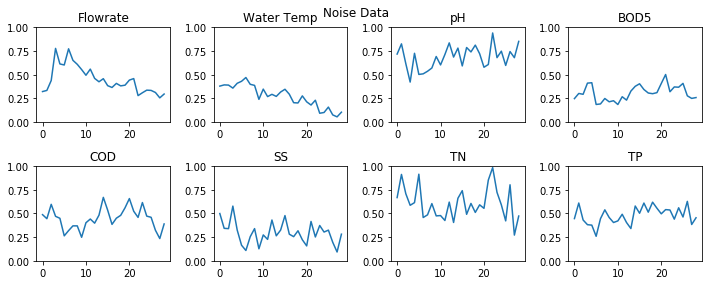

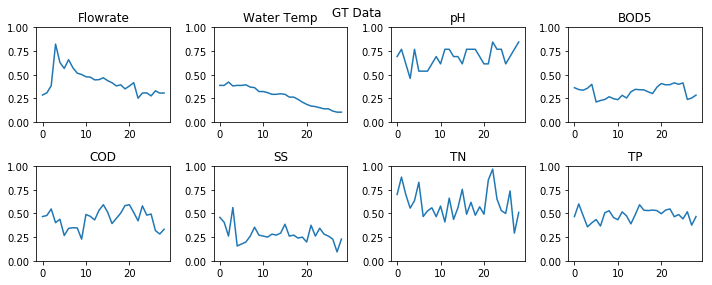

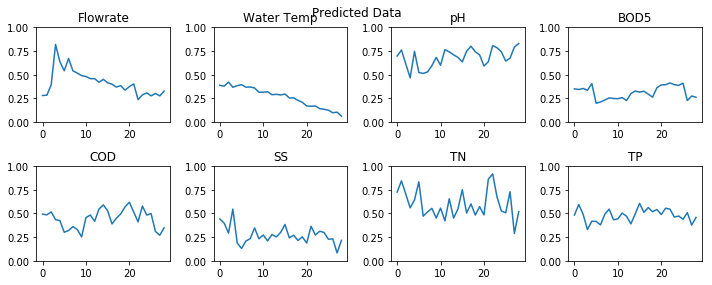

In [16]:
autoencoder_unet.fit(x = data_x,
                      y = data_y, 
                      epochs=100, 
                      batch_size=16, 
                      shuffle=True,
                      verbose=0)
autoencoder_unet.evaluate(data_x,data_y)
pred = autoencoder_unet.predict(data_x)
print(pred.shape)
plot_data(data_x[125,:,:,0], title='Noise Data', scaled=True)
plot_data(data_y[125,:,:,0], title='GT Data', scaled=True)
plot_data(pred[125,:,:,0], title='Predicted Data', scaled=True)

#### Variational
https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [17]:
Image(url= "https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png")

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def VAE(input_shape, latent_dim):
    # VAE model = encoder + decoder
    # build encoder model
    intermediate_dim = 512
    xi = Input(shape=input_shape, name='encoder_input')
    x1 = L.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  activation='relu',
                  padding='valid')(xi)
    x1 = L.MaxPooling2D()(x1)
    
    shape = K.int_shape(x1)
    x1 = L.Flatten()(x1)
    x1 = L.Dense(intermediate_dim, activation='relu')(x1)
    
    z_mean = L.Dense(latent_dim, name='z_mean')(x1)
    z_log_var = L.Dense(latent_dim, name='z_log_var')(x1)
    z = L.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    x2 = L.Dense(intermediate_dim, activation='relu')(z)
    x2 = L.Dense(shape[1] * shape[2] * shape[3])(x2)
    x2 = L.Reshape((shape[1], shape[2], shape[3]))(x2)
    x2 = L.UpSampling2D()(x2)
    
    x2 = L.Conv2DTranspose(filters=64,
                           kernel_size=3,
                           strides=1,
                           activation='relu',
                           padding='valid')(x2)
    xo = L.Conv2DTranspose(filters=1,
                            kernel_size=3,
                            padding='same')(x2)
    
    vae = Model(xi, xo, name='vae_mlp')
    return vae
    
# Autoencoder(input_shape(m,n), layer_filters, latent dim)
vae = VAE(data_x.shape[1:], 256)
vae.summary()
# Compile ,fit and evaluate model to the data
vae.compile(loss='mse', optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 30, 8, 1)     0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 6, 64)    640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 3, 64)    0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2688)         0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
dense_2 (D

171/171 [==============================] - 0s 1ms/sample - loss: 3.8754e-04
(171, 30, 8, 1)


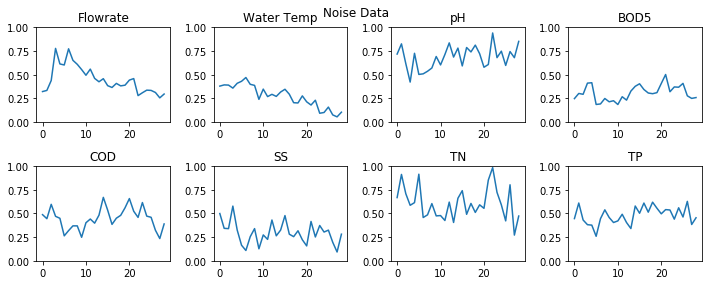

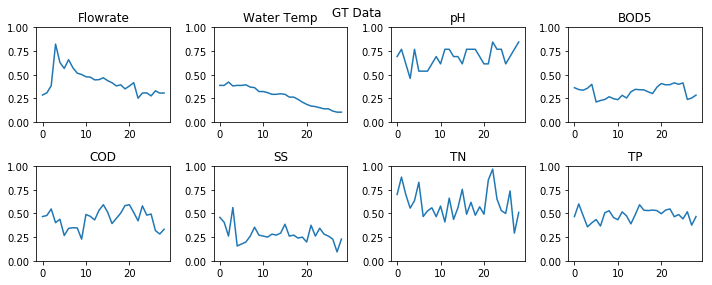

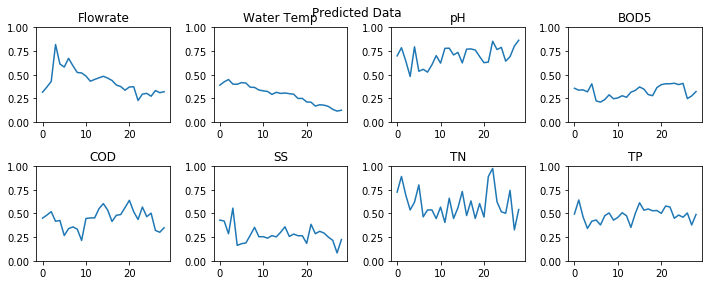

In [19]:
vae.fit(  x = data_x,
          y = data_y, 
          epochs=100, 
          batch_size=16, 
          shuffle=True,
          verbose=0)
vae.evaluate(data_x,data_y)
pred = vae.predict(data_x)
print(pred.shape)
plot_data(data_x[125,:,:,0], title='Noise Data', scaled=True)
plot_data(data_y[125,:,:,0], title='GT Data', scaled=True)
plot_data(pred[125,:,:,0], title='Predicted Data', scaled=True)

---
### Recurrent Network
https://www.cs.toronto.edu/~tingwuwang/rnn_tutorial.pdf

#### Basic Network

In [ ]:
Image(url= "http://www.easy-tensorflow.com/images/NN/01.png")

#### Bidirectional RNN

In [ ]:
Image(url= "https://miro.medium.com/max/1200/1*6QnPUSv_t9BY9Fv8_aLb-Q.png")

---
### TCN
https://github.com/philipperemy/keras-tcn

- TCNs exhibit longer memory than recurrent architectures with the same capacity.
- Constantly performs better than LSTM/GRU architectures on a vast range of tasks (Seq. MNIST, Adding Problem, Copy Memory, Word-level PTB...).
- Parallelism, flexible receptive field size, stable gradients, low memory requirements for training, variable length inputs...



In [ ]:
Image(url= "https://raw.githubusercontent.com/philipperemy/keras-tcn/master/misc/Dilated_Conv.png")

In [ ]:
from keras.layers import Dense
from keras.models import Input, Model

from tcn import TCN

batch_size, timesteps, input_dim = None, 20, 1


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train


i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False)(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

In [ ]:
from tcn import TCN

batch_size, timesteps, input_dim = None, 30, 8


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train


i = Input(batch_shape=(batch_size, timesteps, input_dim))
o = TCN(return_sequences=False)(i)  # The TCN layers are here.
o = Dense(1)(o)
m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

---
### Applications

Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.
Weights are downloaded automatically when instantiating a model. They are stored at
https://keras.io/applications/

- [Xception](https://keras.io/applications/#xception)
- [VGG16](https://keras.io/applications/#vgg16)
- [VGG19](https://keras.io/applications/#vgg19)
- [ResNet, ResNetV2, ResNeXt](https://keras.io/applications/#resnet)
- [InceptionV3](https://keras.io/applications/#inceptionv3)
- [InceptionResNetV2](https://keras.io/applications/#inceptionresnetv2)
- [MobileNet](https://keras.io/applications/#mobilenet)
- [MobileNetV2](https://keras.io/applications/#mobilenetv2)
- [DenseNet](https://keras.io/applications/#densenet)
- [NASNet](https://keras.io/applications/#nasnet)


---
#### Transfer Learning

Refs:

https://medium.com/@venkatakrishna.jonnalagadda/sparse-stacked-and-variational-autoencoder-efe5bfe73b64
https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2
https://medium.com/@dmonn/what-are-variational-autoencoders-a-simple-explanation-ea7dccafb0e3
https://colah.github.io/posts/2014-07-Conv-Nets-Modular/
https://colah.github.io/posts/2015-08-Understanding-LSTMs/
https://www.co2.earth/historical-co2-datasets